<a href="https://colab.research.google.com/github/Vasiliki655/DSC511-Introduction/blob/main/Semester_Project_DSC_511.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSC 511 - Big Data Analytics - Group Semester Project
## Reviews of restaurants for pre and post-Covid-19 periods
### Spring Semester 2025


In [1]:
!pip install pyspark

In [2]:
!pip install spark-nlp==4.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.6/531.6 kB 14.5 MB/s eta 0:00:00


In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline, PipelineModel

import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime
from scipy import stats
from sklearn.linear_model import LinearRegression
from datetime import date
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import warnings
from wordcloud import WordCloud
warnings.filterwarnings("ignore")
%matplotlib inline

spark = SparkSession.builder.appName("Introduction to Text Analytics using Spark").getOrCreate()

In [ ]:
print("Hello")

Hello


In [ ]:
print("hello1")

hello1


In [ ]:
print("Alice and Bob")

Alice and Bob


In [ ]:
print("hello")

hello


In [ ]:
#hello

In [ ]:
#pre-Covid dataset

from google.colab import drive

drive.mount('/content/drive')

file_path0 = "/content/drive/MyDrive/precovid_reviews.csv"

# Load CSV as DataFrame
pre_df = spark.read.options(header='True', inferSchema='True', delimiter=',',multiline = True, escape = '"').csv(file_path0)


# Show the first few rows
pre_df.show(5)

Mounted at /content/drive


In [ ]:
#post-Covid dataset

from google.colab import drive

drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/postcovid_reviews.csv"

# Load CSV as DataFrame
post_df = spark.read.options(header='True', inferSchema='True', delimiter=',',multiline = True, escape = '"').csv(file_path)


# Show the first few rows
post_df.show(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+--------------------+--------------------+-------------------+------+---------+-----------+-------------+--------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+
|         business_id|                name|            address|state_|     city|postal_code|     latitude|     longitude|stars|review_count|is_open|          categories|               hours|           review_id|             user_id|customer_stars|useful|funny|cool|               text_|              date_|
+--------------------+--------------------+-------------------+------+---------+-----------+-------------+--------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+---

### Categories column

In [ ]:
post_df.select("categories").distinct().show()

+--------------------+
|          categories|
+--------------------+
|Caterers, Food, E...|
|Breakfast & Brunc...|
|Tex-Mex, Nightlif...|
|Beer Bar, Bars, B...|
|Hot Dogs, Sandwic...|
|Restaurants, Buff...|
|Sandwiches, Mexic...|
|Vietnamese, Soup,...|
|Italian, Pizza, D...|
|Restaurants, Sala...|
|Food Trucks, Rest...|
|Gastropubs, Bars,...|
|Spanish, Desserts...|
|Bars, American (T...|
|Restaurants, Food...|
|Chicken Wings, Fa...|
|American (Traditi...|
|Restaurants, Sala...|
|Restaurants, Food...|
|Restaurants, Ital...|
+--------------------+
only showing top 20 rows



## Reviews column

In [ ]:
cleaned_precov_df = pre_df.withColumn("Reviews",
    regexp_replace(lower(pre_df["text_"]), "[^a-zA-Z0-9\s]", ""))

cleaned_precov_df.select("Reviews").show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
cleaned_postcov_df = post_df.withColumn("Reviews",
    regexp_replace(lower(post_df["text_"]), "[^a-zA-Z0-9\s]", ""))

cleaned_postcov_df.select("Reviews").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Removing stopwords

In [ ]:

cleaned_precov_df = cleaned_precov_df.withColumn(
    "cleaned_reviews",
    when(col("Reviews").isNotNull(), regexp_replace("Reviews", "[\n,]+", ""))
    .otherwise("")  # Replace NULLs with an empty string
)

# Tokenize text into words
tokenized_precov_df = cleaned_precov_df.withColumn("words", split(col("cleaned_reviews"), " "))

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words_pre")
filtered_precov_df = remover.transform(tokenized_precov_df)

# Filter out empty lists after stopword removal
filtered_precov_df = filtered_precov_df.filter(
    (col("filtered_words_pre").isNotNull()) & (size(col("filtered_words_pre")) > 0)
)

# Show cleaned and filtered results
filtered_precov_df.select("filtered_words_pre").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import split, regexp_replace
from pyspark.ml.feature import StopWordsRemover

# Remove \n\n and replace with a space
cleaned_postcov_df = cleaned_postcov_df.withColumn(
    "cleaned_reviews", regexp_replace("Reviews", "\n+", " ")  # Replaces multiple newlines with a space
)

# Tokenize text into words
tokenized_postcov_df = cleaned_postcov_df.withColumn("words", split("cleaned_reviews", " "))

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words_post")
filtered_postcov_df = remover.transform(tokenized_postcov_df)

# Show result
filtered_postcov_df.select("filtered_words_post").show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
filtered_precov_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state_: string (nullable = true)
 |-- city: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- is_open: integer (nullable = true)
 |-- categories: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- customer_stars: integer (nullable = true)
 |-- useful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- cool: integer (nullable = true)
 |-- text_: string (nullable = true)
 |-- date_: timestamp (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- cleaned_reviews: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNul

In [ ]:
filtered_precov_df_sample = filtered_precov_df.sample(fraction=0.001)

In [ ]:
filtered_precov_df_sample = filtered_precov_df.sample(fraction=0.3)
filtered_precov_df_sample.select(explode(col("filtered_words_pre")).alias("word")).count()

149028259

In [ ]:
filtered_precov_df.select("filtered_words_pre").show()

+--------------------+
|  filtered_words_pre|
+--------------------+
|[setting, perfect...|
|[twice, really, g...|
|[great, coffee, p...|
|[think, rice, dis...|
|[ordered, origina...|
|[place, truly, hi...|
|[place, best, chi...|
|[yalla, lunch, to...|
|[incredible, donu...|
|[dont, bother, go...|
|[overall, good, w...|
|[husband, shared,...|
|[located, german,...|
|[let, start, sayi...|
|[dishes, executed...|
|[went, sunday, fi...|
|[still, exception...|
|[treat, , party, ...|
|[love, place, foo...|
|[wow, thank, yelp...|
+--------------------+
only showing top 20 rows



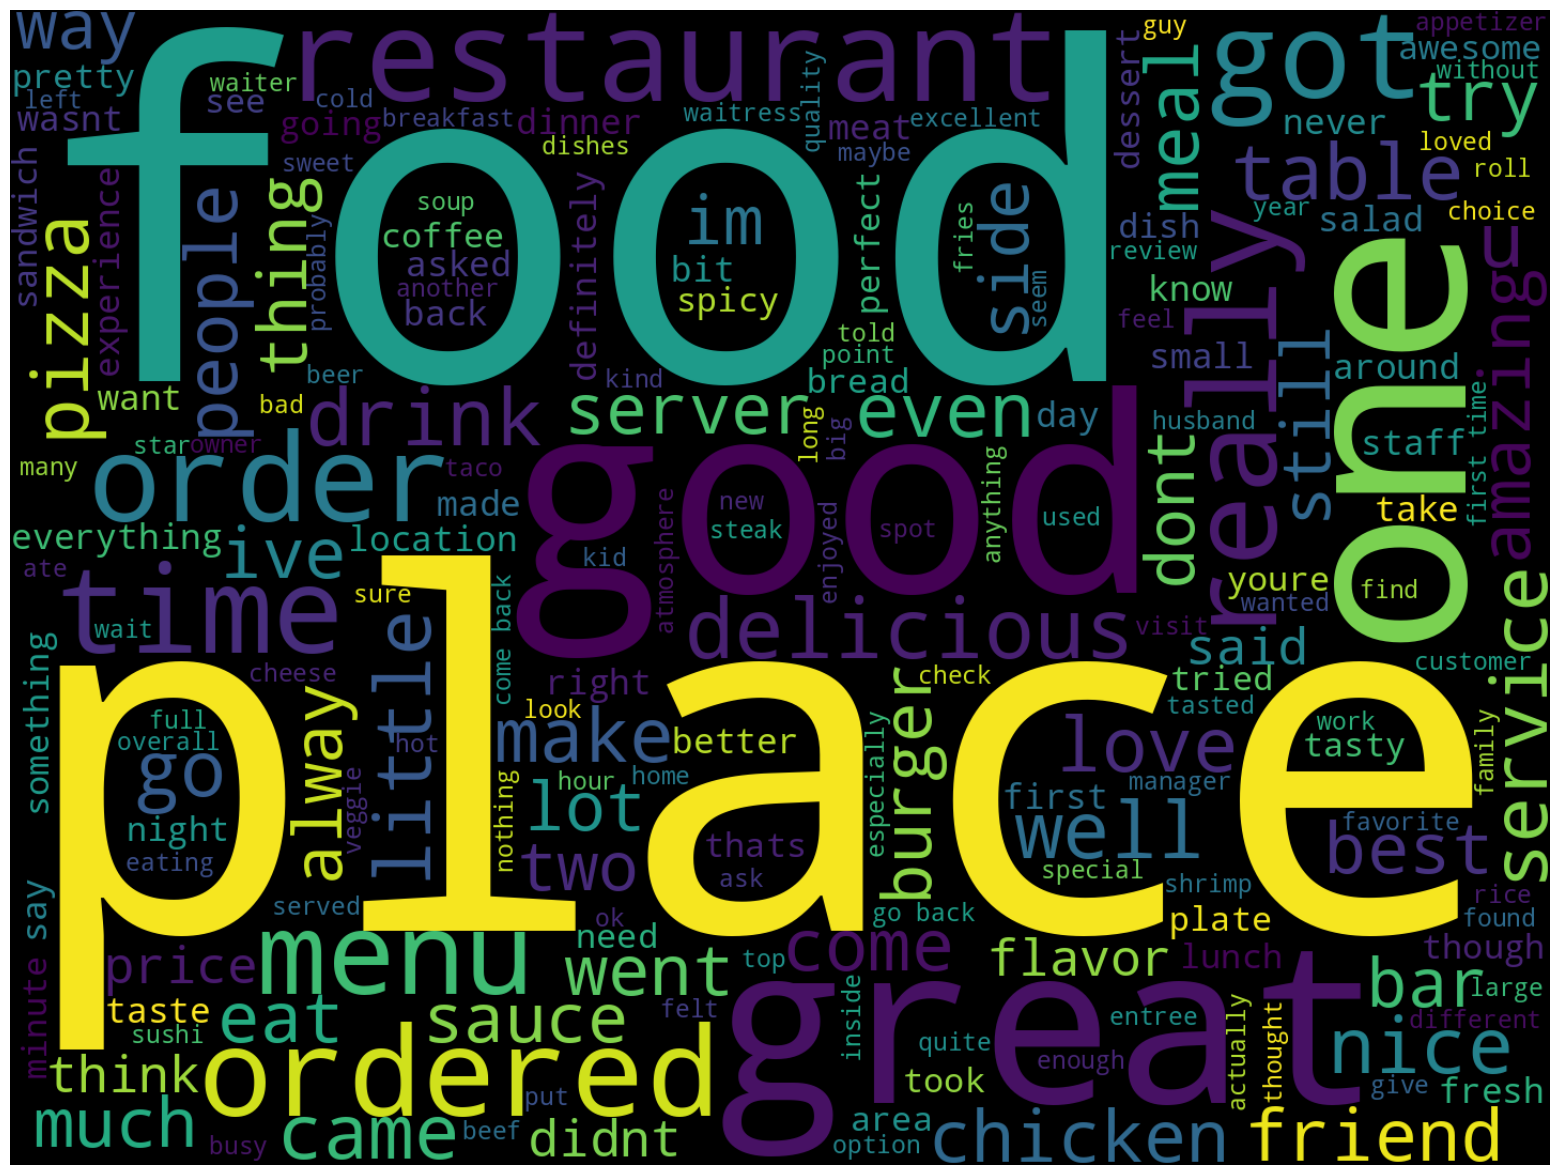

In [ ]:
# Convert Spark DataFrame to Pandas (collecting only the text column)
text_data_pre = ' '.join([item for sublist in filtered_precov_df_sample.select("filtered_words_pre").rdd.flatMap(lambda x: x).collect() for item in sublist])

# Generate the word cloud
cloud_pre = WordCloud(width=1440, height=1080, max_words=200).generate(text_data_pre)

# Display the word cloud
plt.figure(figsize=(20, 15))
plt.imshow(cloud_pre, interpolation="bilinear")
plt.axis('off')
plt.show()

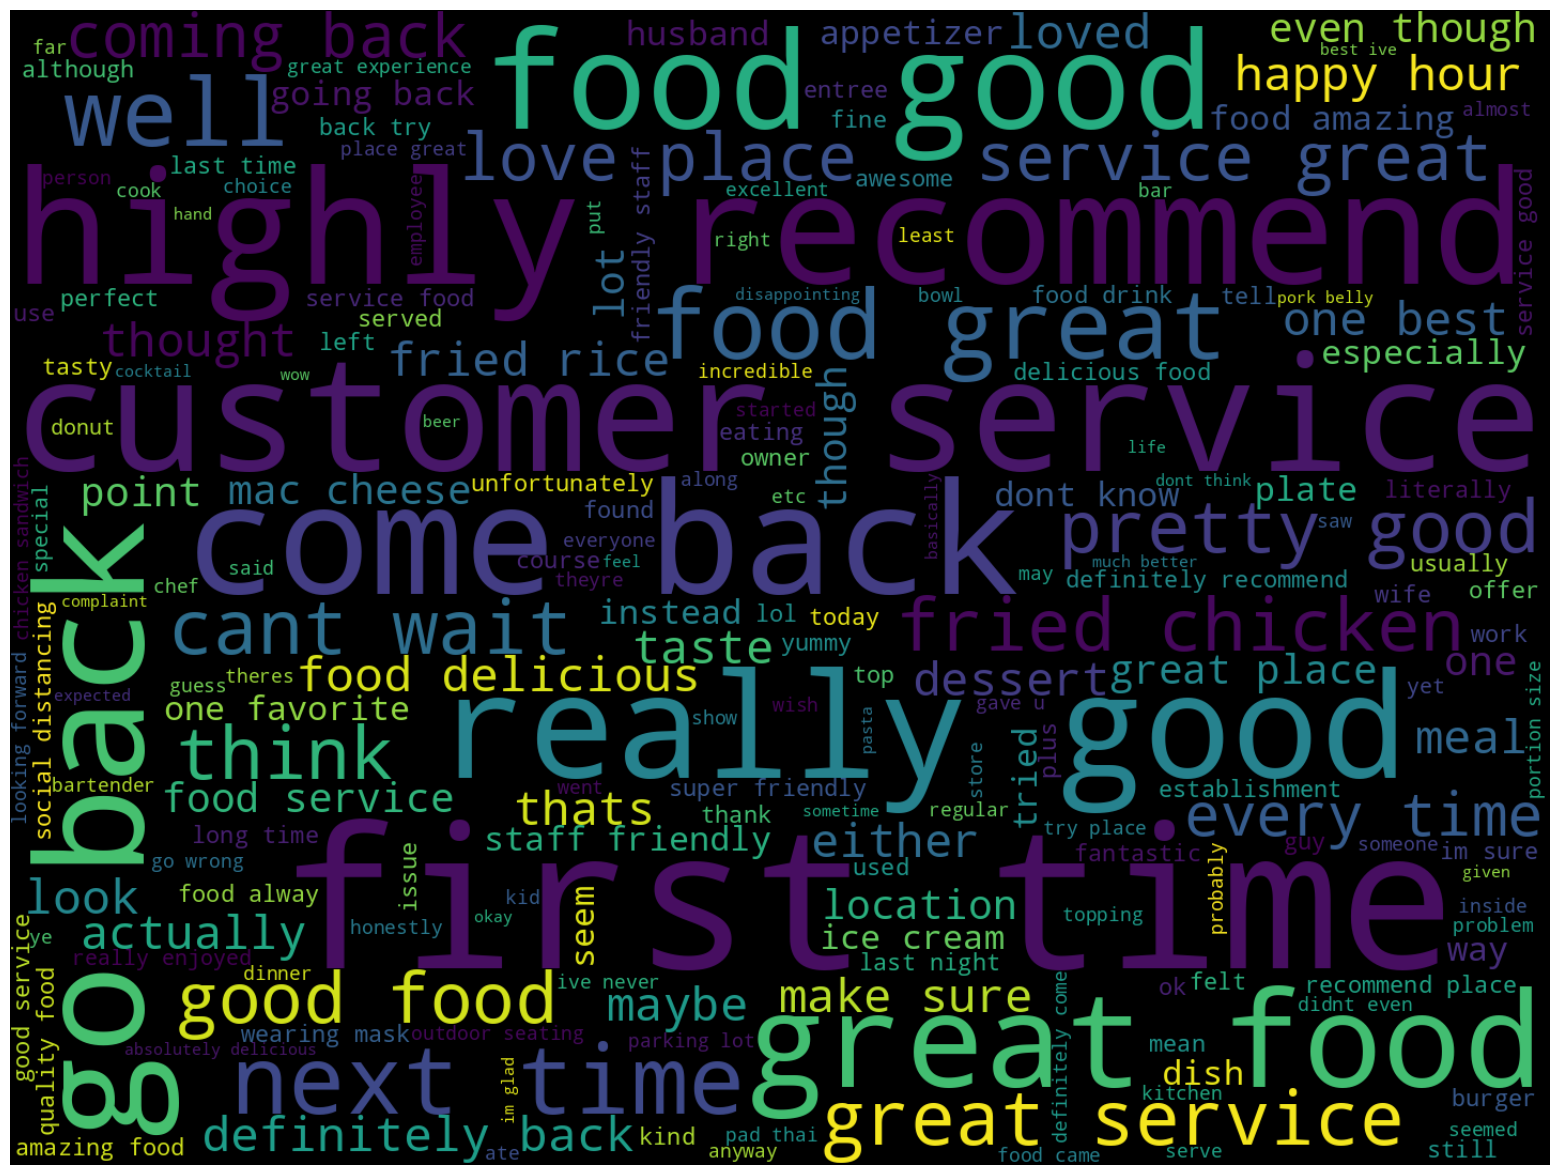

In [ ]:
# Convert Spark DataFrame to Pandas (collecting only the text column)
text_data_post = ' '.join([item for sublist in filtered_postcov_df.select("filtered_words_post").rdd.flatMap(lambda x: x).collect() for item in sublist])

# Generate the word cloud
cloud_post = WordCloud(width=1440, height=1080, max_words=200).generate(text_data_post)

# Display the word cloud
plt.figure(figsize=(20, 15))
plt.imshow(cloud_post, interpolation="bilinear")
plt.axis('off')
plt.show()

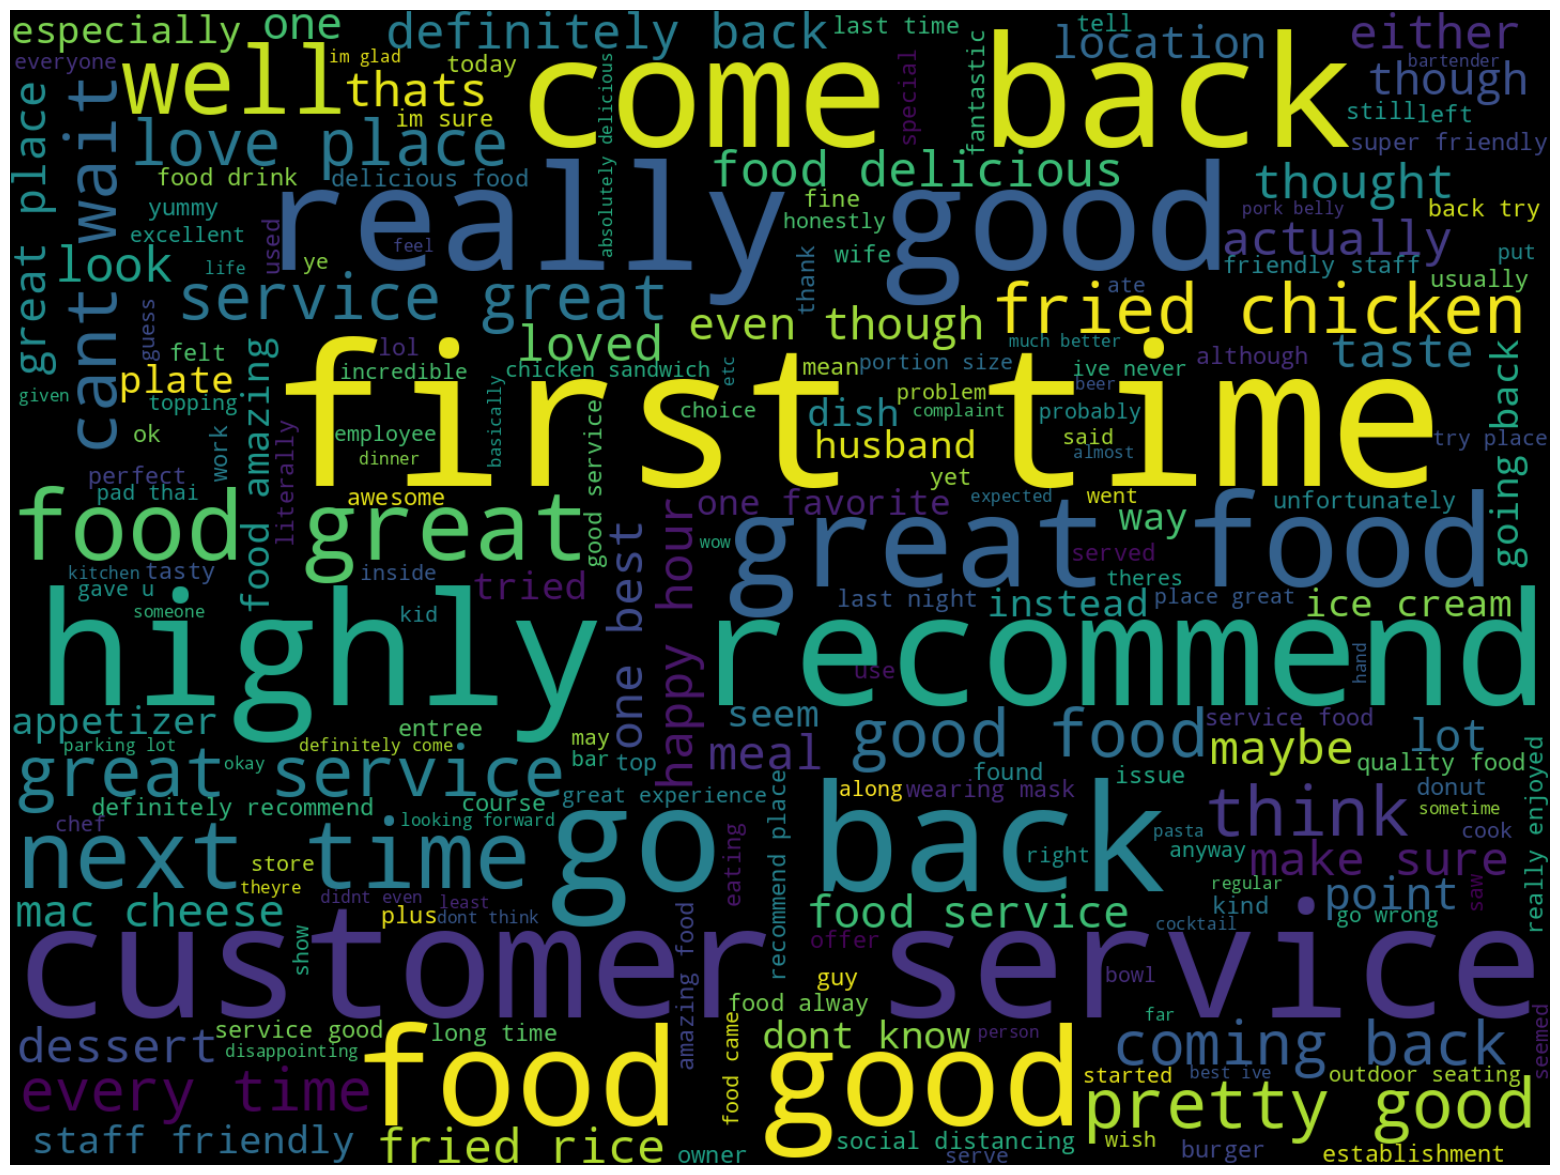

In [ ]:
# Convert Spark DataFrame to Pandas (collecting only the text column)
text_data_post = ' '.join([item for sublist in filtered_precov_df.select("filtered_words").rdd.flatMap(lambda x: x).collect() for item in sublist])

# Generate the word cloud
cloud = WordCloud(width=1440, height=1080, max_words=200).generate(text_data_post)

# Display the word cloud
plt.figure(figsize=(20, 15))
plt.imshow(cloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Sentiment Analysis on Reviews

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.pipeline import Pipeline

# Tokenize the text
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Train a Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="sentiment")  # 1=positive, 0=negative

# Build Pipeline
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])

# Train Model
model = pipeline.fit(training_data)
predictions = model.transform(test_data)

predictions.select("cleaned_text", "prediction").show(5)
